In [1]:
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from hydra.utils import instantiate

from icicl.utils.experiment_utils import extract_config
from icicl.data.on_off_grid import OOTGBatch, SyntheticOOTGGenerator
from icicl.data.gp import RandomScaleGPGenerator

%load_ext autoreload
%autoreload 2

/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Trying OOTG Batches!

In [2]:
OOTGGen = SyntheticOOTGGenerator(
    off_grid_generator=RandomScaleGPGenerator(
        dim=1, 
        kernel_type= "eq", min_log10_lengthscale= -0.602, max_log10_lengthscale= 0.602, noise_std= 0.2,
        num_tasks=2,
        min_num_ctx = 1, max_num_ctx = 64, min_num_trg = 128, max_num_trg = 128,
        context_range = [[-2.0, 2.0]],
        target_range = [[-3.0, 3.0]],
        samples_per_epoch = 16384,
        batch_size = 16
    ),
    grid_range=[[-3.0, 3.0]],
    points_per_unit=8,
    samples_per_epoch = 16000,
    batch_size = 16,
)

In [3]:
for batch in OOTGGen:
    print(batch.xc_on_grid.shape)
    print(batch.yc_on_grid.shape)
    print(batch.yc_off_grid.shape)
    print(batch.xt.shape)
    break

torch.Size([16, 65, 1])
torch.Size([16, 65, 1])
torch.Size([16, 64, 1])
torch.Size([16, 128, 1])


/home/erl50/.conda/envs/tnp/lib/python3.9/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


In [5]:
from icicl.models.ootg_tnp import OOTGSetConvTNPDEncoder
from icicl.utils.helpers import preprocess_observations
from icicl.utils.conv import flatten_grid, unflatten_grid
from icicl.networks.mlp import MLP

dim = 1
xy_encoder = MLP(in_dim= 3 + dim, out_dim = 5, num_layers = 2, width= 32)

grid_encoder = OOTGSetConvTNPDEncoder(dim=dim, init_lengthscale=2 * 1/ 4, xy_encoder = xy_encoder, transformer_encoder=None)

patch_size = 16
conv = torch.nn.Conv1d(in_channels=5, out_channels=5, kernel_size=patch_size, stride=patch_size)

def coarsen_grid(z: torch.Tensor) -> torch.Tensor:
        
        # z will be of shape (batch, num_on_grid, embed_dim)
        z = unflatten_grid(z, dim=dim)
        # move 'channels' (i.e embed_dim) right after batch
        z = z.movedim(-1, 1)
        z = conv(z)
        # move 'channels' (i.e embed_dim) to end again
        z = z.movedim(1, -1)
        return flatten_grid(z)

for batch in OOTGGen:
    xc, yc = grid_encoder.grid_encode(xc_off_grid=batch.xc_off_grid, yc_off_grid=batch.yc_off_grid, xc_on_grid=batch.xc_on_grid, yc_on_grid=batch.yc_on_grid)
    print(yc.shape)
    yc, yt = preprocess_observations(batch.xt, yc)
    print(yc.shape)
    zc = torch.cat((xc, yc), dim=-1)
    print(zc.shape)
    # So zc is 3 + xdim
    zc = xy_encoder(zc)
    print(zc.shape)
    zc = coarsen_grid(zc)  
    print(zc.shape) 

    zt = torch.cat((batch.xt, yt), dim=-1)
    zt = xy_encoder(zt)
    print(zt.shape)
    break

torch.Size([16, 65, 2])
torch.Size([16, 65, 3])
torch.Size([16, 65, 4])
torch.Size([16, 65, 5])
torch.Size([16, 4, 5])
torch.Size([16, 128, 5])


# Profiling

In [21]:
config_tnp, _ = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", [])
config_vit, _ = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_vit.yml", [])
pl.seed_everything(config_tnp.misc.seed)
experiment_tnp = instantiate(config_tnp)
experiment_vit = instantiate(config_vit)
pl.seed_everything(experiment_tnp.misc.seed)

Global seed set to 0


Global seed set to 0


0

In [28]:
from icicl.utils.experiment_utils import np_loss_fn
import time

tnp = experiment_tnp.model
vit = experiment_vit.model
gen_train = experiment_tnp.generators.train

start = time.time()
for i, batch in enumerate(gen_train):
    #model.encoder.grid_encode(batch.xc_off_grid, batch.yc_off_grid, batch.xc_on_grid, batch.yc_on_grid)
    np_loss_fn(tnp, batch)
    
    if i > 100:
        break

print(f"This took {time.time() - start} seconds")

This took 14.1860032081604 seconds


# ConvSet TNP Encoder Tests

In [60]:
%load_ext autoreload
%autoreload 2

from icicl.utils.conv import make_grid, flatten_grid, unflatten_grid
import torch 
import math
import einops

grid_range = torch.as_tensor([[-5,5]])
print(grid_range)

batch_shape = torch.Size((2,))

xmin = grid_range[:, 0].repeat(*batch_shape, 1)
xmax = grid_range[:, 1].repeat(*batch_shape, 1)

grid = make_grid(
    xmin = xmin, 
    xmax = xmax, 
    points_per_unit = 4, 
    margin = 0)

print(grid.shape)
print(grid.amin(), grid.amax())





plat = flatten_grid(grid)

onplat = unflatten_grid(plat)


torch.allclose(grid, onplat)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([[-5,  5]])
torch.Size([2, 65, 1])
tensor(-5.) tensor(5.)


True

# Getting the true log-likelihood

In [5]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import lightning.pytorch as pl
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config

config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", ["params.ignore_on_grid=False"])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["num_tasks"] = 2 # TODO change
config["generators"]["off_grid_generator_val"]["task_correlation"] = 0.85
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

batches = []
for batch in tqdm(experiment.generators.val, total=len(experiment.generators.val), desc="Validation"):
        batches.append(batch)


Global seed set to 0
Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Validation: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]


In [6]:
print(batches[0].xc.shape, batches[0].yc.shape, batches[0].xt.shape, batches[0].yt.shape)

torch.Size([16, 110, 1]) torch.Size([16, 110, 1]) torch.Size([16, 128, 1]) torch.Size([16, 128, 1])


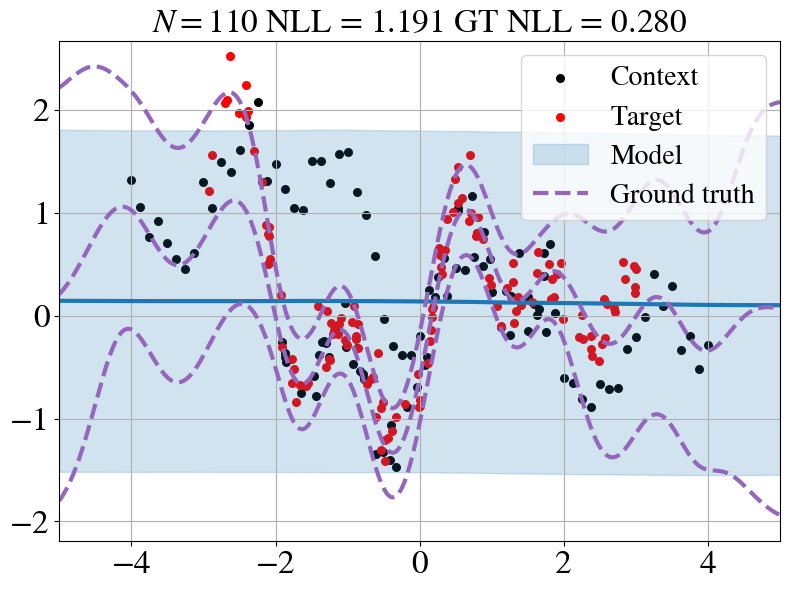

In [7]:
plot(model=experiment.model, batches=batches, num_fig=1)

### Plotting just the data

Global seed set to 0
Global seed set to 0


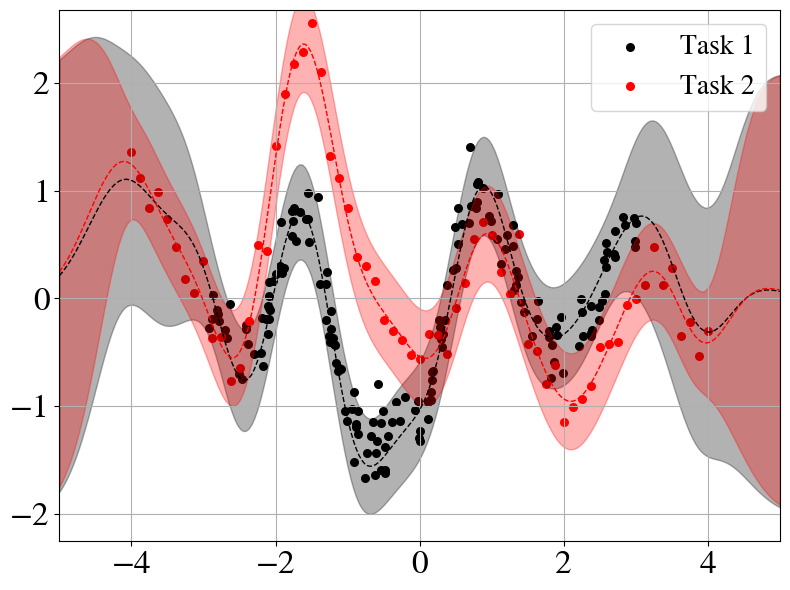

In [ ]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from icicl.data.synthetic import SyntheticBatch
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config
from icicl.data.gp import MultitaskGPModel

config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", ["params.ignore_on_grid=False"])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["context_range"] = [[-3.0, 3.0]]
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

for batch in experiment.generators.val:
        pass

x_plot = torch.linspace(-5.0, 5.0, 256)[None, :, None]
def plot_with_std(means, stds, color):
    plt.plot(
        x_plot[0,:,0].cpu(),
        means[0, :].cpu(),
        "--",
        color=color,
        lw=1,
    )

    plt.fill_between(
        x_plot[0,:,0].cpu(),  
        means[0, :].cpu() - 2 * stds[0, :].cpu(),  
        means[0, :].cpu() + 2 * stds[0, :].cpu(),
        color=color,
        alpha=0.3,
    )

# Make figure for plotting
fig = plt.figure(figsize=(8.0, 6.0))

# Plot context and target points
plt.scatter(
    torch.concat((batch.xc_off_grid, batch.xt), dim=-2)[0, :, 0].cpu().numpy(),
    torch.concat((batch.yc_off_grid, batch.yt), dim=-2)[0, :, 0].cpu().numpy(),
    c="k",
    label="Task 1",
    s=30,
)

plt.scatter(
    batch.xc_on_grid[0, :, 0].cpu().numpy(),
    batch.yc_on_grid[0, :, 0].cpu().numpy(),
    c="r",
    label="Task 2",
    s=30,
)

with torch.no_grad():
    gt_mean, gt_std, _ = batch.gt_pred(
        xc=batch.xc[:1],
        yc=batch.yc[:1],
        xt=x_plot,
        batch=batch
    )
    # Plot ground truth
    plot_with_std(gt_mean, gt_std, color="k")

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise = batch.gt_pred.noise_std ** 2
    num_off_grid = batch.xc_off_grid.shape[-2]
    xc_labels = torch.concat((
        torch.zeros(num_off_grid, 1),
        torch.ones(batch.xc[:1].shape[-2] - num_off_grid, 1)), 
    ).to(torch.long)
    model = MultitaskGPModel((batch.xc[:1].to(torch.float64), xc_labels), batch.yc[:1].squeeze(-1).to(torch.float64), batch.gt_pred.kernel, likelihood, index_kernel=batch.gt_pred.index_kernel)
    model.eval() 
    outputDist = likelihood(model(x_plot[:1].to(torch.float64), torch.ones(x_plot[:1].shape[-2], 1, dtype=torch.long)))

    plot_with_std(outputDist.mean, outputDist.stddev, color="r")

plt.grid()
plt.xlim((-5.0, 5.0))

y_max = 0.25 + max(gt_mean[0, ...] + 2 * gt_std[0, ...])
y_min = -0.25 + min(gt_mean[0, ...] - 2 * gt_std[0, ...])
y_lim = (y_min.cpu(), y_max.cpu())
plt.ylim(y_lim)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc="upper right", fontsize=20)
plt.tight_layout()

if True:
    plt.savefig("hadamard_gp_data_example.svg")

# MHCA Encoding Approach

In [14]:
%load_ext autoreload
%autoreload 2

import torch

from icicl.networks.attention_layers import MultiHeadCrossAttentionLayer
from icicl.networks.transformer import TNPDTransformerEncoder

emb_dim = 2
mhca_layer = MultiHeadCrossAttentionLayer(embed_dim=emb_dim, num_heads=2, head_dim=3, feedforward_dim=emb_dim)

on_grid = torch.randn(2, 4, emb_dim)
off_grid = torch.randn(2, 3, emb_dim)

print(on_grid[0])
off_grid[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([[ 0.8578,  0.8750],
        [-0.2606, -0.6350],
        [ 0.6655,  1.6336],
        [-0.7549,  1.6506]])


tensor([[-0.4460,  0.3409],
        [-0.9241,  0.7682],
        [ 2.1478, -0.8119]])

In [15]:
# natively find idx's:
for idx,batch in enumerate(off_grid):
    for vec in batch:
        beste = (on_grid[idx] - vec).abs().sum(dim=-1).argmin()
        print(f"batch{idx}: {beste}")

batch0: 1
batch0: 3
batch0: 1
batch1: 1
batch1: 3
batch1: 0


In [16]:
B, U, E = off_grid.shape # 'U'nstructured
S = on_grid.shape[-2] # 'S'tructured


ap = on_grid.repeat(U,1, 1, 1).movedim(0,1)
bp = off_grid.repeat(S,1, 1, 1).movedim(0,2)

idx = (bp - ap).abs().sum(dim=-1).argmin(dim=2)
print(idx)

batch_idx = torch.arange(B).unsqueeze(-1).repeat(1, U)
print(batch_idx.shape)
u_idx = torch.arange(U).repeat(B, 1)
print(u_idx.shape)

mask = torch.zeros(B, U, S, dtype=torch.long)
mask[batch_idx, u_idx, idx] = 1
mask

tensor([[1, 3, 1],
        [1, 3, 0]])
torch.Size([2, 3])
torch.Size([2, 3])


tensor([[[0, 1, 0, 0],
         [0, 0, 0, 1],
         [0, 1, 0, 0]],

        [[0, 1, 0, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0]]])

In [18]:
max_patch = mask.sum(dim=1).amax() + 1
print("max_patches + 1 =", max_patch)

cumcount_idx = (mask.cumsum(dim=1) - 1)[batch_idx, u_idx, idx]
cumcount_idx

max_patches + 1 = tensor(3)


tensor([[0, 0, 1],
        [0, 0, 0]])

In [26]:
FAKE_TOKEN = -torch.inf
gridded = torch.full((B, S, max_patch, E), FAKE_TOKEN)
gridded[batch_idx, idx, cumcount_idx] = off_grid[batch_idx, torch.arange(U)]


batch_idx_s = torch.arange(B).unsqueeze(-1).repeat(1, S)
s_idx = torch.arange(S).repeat(B, 1)

gridded[batch_idx_s, s_idx, -1] = on_grid[batch_idx_s, torch.arange(S)]
gridded

tensor([[[[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.8578,  0.8750]],

         [[-0.4460,  0.3409],
          [ 2.1478, -0.8119],
          [-0.2606, -0.6350]],

         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.6655,  1.6336]],

         [[-0.9241,  0.7682],
          [   -inf,    -inf],
          [-0.7549,  1.6506]]],


        [[[ 0.8962, -0.1175],
          [   -inf,    -inf],
          [ 1.1895,  0.7400]],

         [[-1.4705, -0.8686],
          [   -inf,    -inf],
          [-0.0874, -0.2873]],

         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.6964, -1.7951]],

         [[-1.0830,  0.9049],
          [   -inf,    -inf],
          [-0.7760,  0.8307]]]])

In [24]:
ignore_on_grid = False
if ignore_on_grid:
    gridded[batch_idx_s, s_idx, -1] = torch.arange(E).to(torch.float32)
    print(gridded)

In [6]:
import einops

gridded_stacked = einops.rearrange(gridded, "b s m e -> (b s) m e")
gridded_stacked

tensor([[[ 0.5851, -0.6469],
         [   -inf,    -inf],
         [ 1.2044, -0.7676]],

        [[   -inf,    -inf],
         [   -inf,    -inf],
         [-0.6620, -1.4455]],

        [[-0.0071, -1.1664],
         [   -inf,    -inf],
         [-0.2118, -0.7982]],

        [[ 0.0955,  0.6021],
         [   -inf,    -inf],
         [-0.5246,  0.8562]],

        [[   -inf,    -inf],
         [   -inf,    -inf],
         [ 2.0636, -1.9076]],

        [[-0.2600, -2.2363],
         [   -inf,    -inf],
         [ 0.8117, -0.9124]],

        [[   -inf,    -inf],
         [   -inf,    -inf],
         [-1.3996, -0.2791]],

        [[-0.8217, -0.2493],
         [ 0.1276, -0.4447],
         [-0.7018, -0.1754]]])

In [7]:
stacked_mask_idx = gridded_stacked.sum(-1) == FAKE_TOKEN

att_mask = torch.ones(gridded_stacked.size(0), 1, max_patch, dtype=torch.bool)
att_mask[stacked_mask_idx.unsqueeze(1)] = False
att_mask

tensor([[[ True, False,  True]],

        [[False, False,  True]],

        [[ True, False,  True]],

        [[ True, False,  True]],

        [[False, False,  True]],

        [[ True, False,  True]],

        [[False, False,  True]],

        [[ True,  True,  True]]])

In [8]:
# necessary to not get loads of nans
gridded_stacked[gridded_stacked == FAKE_TOKEN] = 0

In [9]:
latents = torch.randn(S, E)
latents = latents.repeat(B, 1).unsqueeze(1)
latents.shape

torch.Size([8, 1, 2])

In [10]:
output_mask = mhca_layer(latents, gridded_stacked, mask=att_mask)
print(output_mask.shape)
#output_mask
output = einops.rearrange(output_mask, "(b s) 1 e -> b s e", b=B)
print(output.shape)
assert output.shape == (B, S, E)

torch.Size([8, 1, 2])
torch.Size([2, 4, 2])


In [11]:
print(output)

tensor([[[-1.0000,  1.0000],
         [-1.0000,  1.0000],
         [ 1.0000, -1.0000],
         [ 1.0000, -1.0000]],

        [[-1.0000,  1.0000],
         [-1.0000,  1.0000],
         [ 1.0000, -1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<ViewBackward0>)
